# Black Friday Expense Predictor
  
### Description

The aim is to determine the amount of money an individual spends on Black Friday. The dataset we will be using is the Black Friday dataset provided by Kaggle.


### Authors
- Ruel Gordon
- Shumba Brown
- Kode Williams

Copyright © 2018. All Rights Reserved.

### Library Imports

In [0]:
import fnmatch
import math
import random

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns

# This line increases the amount of logging when there is an error.  You can
# remove it if you want less logging
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 25

print ("Libraries loaded.")

# Dataset hosted here
# https://raw.githubusercontent.com/kodewilliams/blackfridaypredictor/master/BlackFriday.csv


Libraries loaded.


### Description of Dataset

The data contains 550,000 purchases by individuals from a multitude of demographics.

**Fields in the data include**:
* User ID
* Product ID
* Product Category
* Gender
* Age Range
* Occupation
* Category of city (A/B/C)
* Length of time in city
* Marital status

<br>    

**Feature Transformations**  

- We will have to perform numerous feature engineering procedures on the features
shown above. 

- Firstly we will have to do some data cleaning on age range and on the length of time in the city; currently they are represented as strings but we want to treat them numerically. Some features we will place in groups as either numerical or categorical for training purposes.

- We will also do one transformation on the purchase (which is our label and predicted value), we would like to represent the purchase value in bins or categories. For example, if someone spends 600 dollars that person might be spending in a "lower bin" but they spent 7000 they might be spending in a "higher bin"; we will also have bins or groups (middle low, middle high) in between.
 
<br>

**Visualization**

- We plan to make scatter plots after the data is sanitized and the features are transformed so we can see how the data looks in comparison to the label.

- We will also create calibration plots and ROC curves etc. to see how accurate the model is and will use histograms and other statistics graphs to determine what type of scaling to do.




### Prepare Features

In [0]:
# Linearly rescales to the range [0, 1]
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = 1.0 * (max_val - min_val)
  return series.apply(lambda x:((x - min_val) / scale))

# Perform log scaling
def log_scale(series):
  return series.apply(lambda x:math.log(x+1.0))

# Clip all features to given min and max
def clip(series, clip_to_min, clip_to_max):
  # You need to modify this to actually do the clipping versus just returning
  # the series unchanged.
  return series.apply(lambda x: clip_to_min if x <= clip_to_min else (clip_to_max if x >= clip_to_max else x))

In [0]:
# Converts age range to numerical feature
# {'0-17', '51-55', '55+', '46-50', '36-45', '26-35', '18-25'}
def age_to_value(age):
  if age == '55+':
    return 6
  '''elif age == '51-55':
    return 5
  elif age == '46-50':
    return 4
  elif age == '36-45':
    return 3
  elif age == '26-35':
    return 2
  elif age == '18-25':
    return 1
  else:
    return 0'''
  return int(age[0])

# Converts city category to numerical feature
def city_value(category):
  if category == 'A':
    return 2
  elif category == 'B':
    return 1
  return 0

# Converts city stay to numerical feature
def city_stay(stay):
  return int(stay[0])

In [0]:
# Show plots and histograms for features

NUMERICAL_FEATURES = [("occupation", 20), ("city_years", 5), ("age", 7), ("product_category", 50)]

def draw_histograms(dataframe, feature_name):
  plt.figure(figsize=(20, 4))
  plt.subplot(1, 3, 1)
  plt.title(feature_name[0])
  histogram = dataframe[feature_name[0]].hist(bins=feature_name[1])

  plt.subplot(1, 3, 2)
  plt.title("Linear Scaled")
  scaled_features = pd.DataFrame()
  scaled_features[feature_name[0]] = linear_scale(dataframe[feature_name[0]])
  histogram = scaled_features[feature_name[0]].hist(bins=feature_name[1])
  
  plt.subplot(1, 3, 3)
  plt.title("Log Scaled")
  log_normalized_features = pd.DataFrame()
  log_normalized_features[feature_name[0]] = log_scale(dataframe[feature_name[0]])
  histogram = log_normalized_features[feature_name[0]].hist(bins=feature_name[1])

# for FEATURE in NUMERICAL_FEATURES:
#   draw_histograms(training_data, FEATURE)
#   print("\n")

In [0]:
def scatter_plot(features, targets, slopes=[], biases=[], model_names=[]):
  """ Creates a scatter plot of input_feature vs target along with the models.
  
  Args:
    features: list of the input features
    targets: list of targets
    slopes: list of model weight (slope) 
    bias: list of model bias (same size as slopes)
    model_names: list of model_names to use for legend (same size as slopes)
  """      
  # Define some colors to use that go from blue towards red
  colors = [cm.coolwarm(x) for x in np.linspace(0, 1, len(slopes))]
  
  # Generate the Scatter plot
  plt.ylabel("target")
  plt.xlabel("input feature")
  plt.scatter(features, targets, color='black', label="")
  # Add the lines corresponding to the provided models
  for i in range (0, len(slopes)):
    y_0 = slopes[i] * features.min() + biases[i]
    y_1 = slopes[i] * features.max() + biases[i]
    plt.plot([features.min(), features.max()], [y_0, y_1],
             label=model_names[i], color=colors[i])
  if (len(model_names) > 0):
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

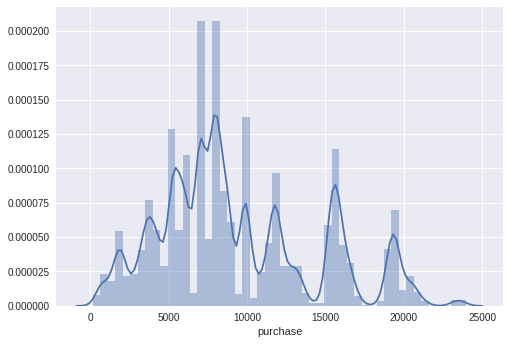

In [0]:
sns.distplot(df.loc[:,'purchase'])

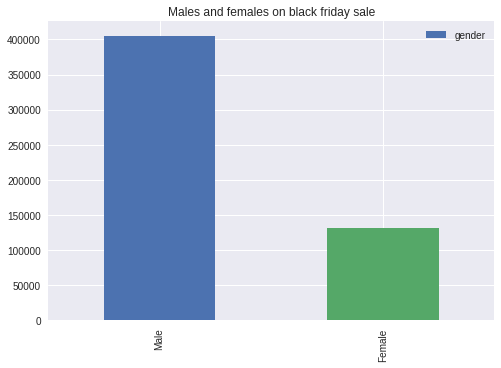

In [0]:
gender_count = df['gender'].value_counts()
gender_count.index = ["Male","Female"]
gender_count.plot(kind = 'bar', title="Males and females on black friday sale", legend="True")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


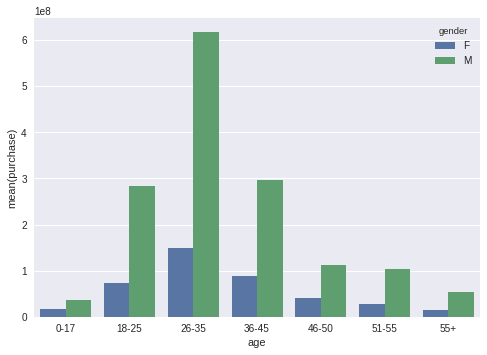

In [0]:
data=df.loc[:,['age','gender', 'purchase']].groupby(['age','gender']).sum()
data.reset_index(drop=False, inplace = True)
sns.barplot(x= data['age'], y=data['purchase'], data = data , hue = data['gender'])

In [0]:
def map_gender(gender):
    if gender == 'M':
        return 1
    else:
        return 0

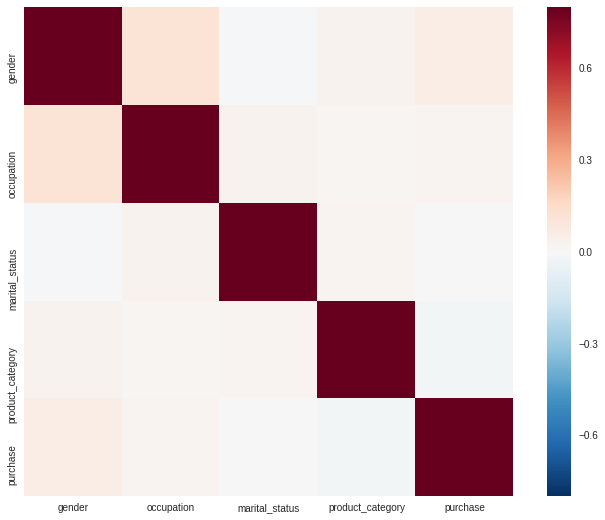

In [0]:
data = df.copy()
data['gender'] = data['gender'].apply(map_gender)

corrmat = data.corr()
fig,ax = plt.subplots(figsize = (12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

### Loss and Input Functions

In [0]:
def calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])

In [0]:
# Function to train any linear model using a calibration plot to help visualize
# the final model

def train_model(linear_regressor, training_features, training_labels,
                validation_features, validation_labels, steps, batch_size):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train
    training_features: The input features from the training data
    training_labels: the labels from the training data
    validatin_features: The input features from the validation data
    validation_labels: the labels from the validation data
    steps: A non-zero `int`, the total number of training steps.
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    The trained regressor
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Set up the training_input_fn, predict_training_input_fn, and
  # predict_validation_input_fn
  training_input_fn = lambda: input_fn(training_features, training_labels,
                                       batch_size=batch_size)
  predict_training_input_fn = lambda: input_fn(training_features,
                                               training_labels,
                                               num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: input_fn(validation_features,
                                                 validation_labels,
                                                 num_epochs=1, shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training losses to generate the training curve
  print("Training model...")
  training_losses = []
  validation_losses = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps
    _ = linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)

    # Use the predict method to compute the training loss
    predictions_1 = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions_1 = np.array([item['predictions'][0] for item in predictions_1])
    training_loss = compute_loss(predictions_1, training_labels)
    training_losses.append(training_loss) 
    
    # Use the predict method to compute the validation loss
    predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    validation_loss = compute_loss(predictions, validation_labels)
    validation_losses.append(validation_loss) 
    print("  Training loss, Validation loss after period %02d : %0.3f, %0.3f" % \
      (period, training_loss, validation_loss))
      
  # Now that training is done print the final training and validation loss    
  print("Final Loss (RMSE) on the training data: %0.3f" % training_loss) 
  print("Final Loss (RMSE) on the validation data: %0.3f" % validation_loss) 
  
  # Generate a figure with the learning curve on the left and a calibration
  # plot on the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses, validation_losses)

  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0)
  plt.title("Calibration Plot on Validation Data")
  calibration_plot(predictions, validation_labels)
   
  return linear_regressor

In [0]:
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of losses to plot.
    validation_losses: a list of validation losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)

**Below we will implement the linear classfier - Ruel**




In [0]:
# Retrieve the data set and rename the necessary things

COLUMNS = ["user_id", "product_id", "gender", "age", "occupation",
            "city_category", "stay_in_current_city_years", "marital_status", 
            "product_category_3", "purchase"]

url = "https://raw.githubusercontent.com/kodewilliams/blackfridaypredictor/master/BlackFriday.csv"
df2 = pd.read_csv(url, sep=",", low_memory=False)
df2 = df2.reindex(np.random.permutation(df2.index))
df2.columns = map(str.lower, df2.columns)

df2 = df2[COLUMNS]
df2.rename(index=str, columns={"stay_in_current_city_years": "city_years"}, inplace=True)
df2.rename(index=str, columns={"product_category_3": "product_category"}, inplace=True)
df2['product_category'] = pd.to_numeric(df2['product_category'], errors='coerce')
df2.fillna(0, inplace=True)
df2.drop(['user_id','product_id'], inplace=True, axis=1)

In [0]:
# Removes product category that are 0 because they were Nans
df2 = df2[df2['product_category'] != 0.00]

In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Defines a function to preprocess the data, as well as how to batch,
      shuffle, and repeat it during model training.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def make_roc_curve(predictions, targets):
  """ Plots an ROC curve for the provided predictions and targets.

  Args:
    predictions: the probability that the example has label 1.
    targets: a list of the target values being predicted that must be the
             same length as predictions.
  """  
  false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
      targets, predictions)
  
  plt.ylabel("true positive rate")
  plt.xlabel("false positive rate")
  plt.plot(false_positive_rate, true_positive_rate)
  
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of losses to plot.
    validation_losses: a list of validation losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)

In [0]:
def compute_loss(probabilities, targets):
  """ Computes the log loss for training a linear classifier.
  
  Args:
    probabilities: the model predictions as probabilities
    targets: a list of the target values being predicted that must be the
             same length as probabilities.
    
  Returns:
    The log loss for the provided probabilities and targets.
  """      
  return metrics.log_loss(targets, probabilities)

In [0]:
def define_linear_classifier(learning_rate):
  """ Defines a linear classifer to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate.
    
  Returns:
    A linear classifier created with the given parameters.
  """
  # n_classes basically tells the function to use softmax(multiple) or sigmoid(binary)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
    feature_columns=construct_feature_columns(), n_classes=2,
    optimizer=optimizer
  )  
  return linear_classifier

# Function to train a classifier that a learning curve and ROC curve to help
# evaluate your model.

def train_model(model, training_features, training_labels,
                validation_features, validation_labels, steps, batch_size):
  """Trains a classifier.
  
  Args:
    model: The model to train
    training_features: The input features from the training data
    training_labels: the labels from the training data
    validation_features: The input features from the validation data
    validation_labels: the labels from the validation data
    steps: A non-zero `int`, the total number of training steps.
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    The trained model
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Set up the training_input_fn, predict_training_input_fn, and
  # predict_validation_input_fn
  training_input_fn = lambda: input_fn(training_features, training_labels,
                                       batch_size=batch_size)
  predict_training_input_fn = lambda: input_fn(training_features,
                                               training_labels,
                                               num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: input_fn(validation_features,
                                                 validation_labels,
                                                 num_epochs=1, shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training losses to generate the training curve
  print("Training model...")
  training_losses = []
  validation_losses = []

  for period in range (0, periods):
    # Train the classifier for steps_per_period steps
    _ = model.train(input_fn=training_input_fn, steps=steps_per_period)      
    
    # Use the predict method to compute the predictions as probabilities and
    # from that the training loss.
    probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    probabilities = np.array([item['probabilities'] for item in probabilities])
    training_loss = compute_loss(probabilities, training_labels)
    training_losses.append(training_loss) 
    
    # Also compute the validation loss   
    probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    probabilities = np.array([item['probabilities'] for item in probabilities])
    validation_loss = compute_loss(probabilities, validation_labels)
    validation_losses.append(validation_loss) 
    print("  Training loss, Validation loss after period %02d : %0.3f, %0.3f" % \
      (period, training_loss, validation_loss))
      
  # Now that training is done print the final training and validation loss    
  print("Final Loss (Log Loss) on the training data: %0.3f" % training_loss) 
  print("Final Loss (Log Loss) on the validation data: %0.3f" % validation_loss) 
  
  # Generate a figure with the learning curve on the left and an ROC curve on
  # the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (Loss vs time)")
  plot_learning_curve(training_losses, validation_losses)
  
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0) 
  plt.title("ROC Curve on Validation Data")
  probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
  probabilities = np.array([item['probabilities'] for item in probabilities])

  # ROC curve uses the probability that the label is 1.
  make_roc_curve(probabilities[:, 1], validation_data2[LABEL])
   
  return model

In [0]:
def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns.
  """
  
  # Sample of creating a categorical column with known values.
  gender = tf.contrib.layers.sparse_column_with_keys(
    column_name="gender", keys=['M', 'F'])
  
  # Sample of creating a categorical columns with a hash bucket.    
  # education = tf.contrib.layers.sparse_column_with_hash_bucket("education", hash_bucket_size=50)
  
  # Sample of creating a real-valued column that can be used for numeric data.
  age = tf.contrib.layers.real_valued_column("age")
  marital_status = tf.contrib.layers.real_valued_column("marital_status")
  city_years = tf.contrib.layers.real_valued_column("city_years")

  # Return the set of all feature columns generated.
  feature_columns=[gender, age, marital_status, city_years]
 
  return feature_columns

In [0]:
CATEGORICAL_FEATURES = ["gender"]
NUMERICAL_FEATURES = ["age", "marital_status", "city_years"]
FEATURES = NUMERICAL_FEATURES+CATEGORICAL_FEATURES,
LABEL = "purchase_class"

# Here we define an input functon that uses the training examples generating
# batches of 10 examples
training_input_fn = lambda: input_fn(
    training_data2[FEATURES], training_data2[LABEL], 
    batch_size=10)

# Here we define an input function that will compute the loss over the entire
# training set.
predict_training_input_fn = lambda: input_fn(
    training_data2[FEATURES], training_data2[LABEL], 
    num_epochs=1, shuffle=False)

# Here we define an input function that will compute the loss over the entire
# validation set.
predict_validation_input_fn = lambda: input_fn(
    validation_data2[FEATURES], validation_data2[LABEL], 
    num_epochs=1, shuffle=False)

In [0]:
def prepare_features(dataframe):
  """Prepares the features for the provided dataset.

  Args:
    dataframe: A Pandas DataFrame containing the data set.
  Returns:
    A new DataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  
  # Replace age and city year ranges with numeric values
  processed_features['age'] = (processed_features['age'].apply(lambda x: age_to_value(x)))

  processed_features['city_years'] = processed_features['city_years'].apply(lambda x: city_stay(x))

  processed_features['city_category'] = processed_features['city_category'].apply(lambda x: city_value(x))

  processed_features['purchase'] = clip(processed_features['purchase'], 500, 15000)
  #processed_features['gender'] = processed_features['gender'].apply(lambda x: 1 if x == 'M' else 0)
  processed_features['product_category'] = processed_features['product_category'].apply(lambda x: int(x))

  processed_features[LABEL] = dataframe['purchase'].apply(lambda x: 0 if x <= 2000 else 1)

  return processed_features

In [0]:
n = len(df2.index)
training = int((n * 0.1) // 1)
validation = int(((n * 0.05) // 1) + training)

# Assign a percentage for training data
training_data2 = prepare_features(df2.head(training))
# Assign a percentage for validation data
validation_data2 = prepare_features(df2[training:validation])
# Assign a percentage for test data
test_data2 = prepare_features(df2[training+validation: training+validation+validation])

In [0]:
#def classify_purchase(series):
  
  #return series.apply(lambda x: 0 if x <= 5000 else (1 if x <= 12000 else 2))

#training_data2['purchase'] = classify_purchase(training_data2['purchase'])
#validation_data2['purchase'] = classify_purchase(validation_data2['purchase'])
#test_data2['purchase'] = classify_purchase(test_data2['purchase'])

In [0]:
print(type(training_data2.iloc[1]['purchase_class']))
print(training_data2.head(10))


<class 'numpy.int64'>
       gender  age  occupation  city_category  city_years  marital_status  \
381484      F    1           4              1           1               1   
221356      M    2           3              1           4               1   
313669      M    3           7              2           1               0   
163377      M    2          17              2           4               0   
453916      M    1          12              0           0               0   
390393      M    2           4              1           3               1   
270867      M    2           0              1           4               1   
524801      M    2          14              1           2               1   
359864      M    1           4              2           1               1   
224727      M    3          14              0           0               0   

        product_category  purchase  purchase_class  
381484                14      4189               1  
221356                15

Training model...
  Training loss, Validation loss after period 00 : 0.385, 0.386
  Training loss, Validation loss after period 01 : 0.228, 0.228
  Training loss, Validation loss after period 02 : 0.158, 0.156
  Training loss, Validation loss after period 03 : 0.131, 0.129
  Training loss, Validation loss after period 04 : 0.123, 0.119
  Training loss, Validation loss after period 05 : 0.121, 0.117
  Training loss, Validation loss after period 06 : 0.119, 0.115
  Training loss, Validation loss after period 07 : 0.119, 0.114
  Training loss, Validation loss after period 08 : 0.118, 0.114
  Training loss, Validation loss after period 09 : 0.118, 0.113
Final Loss (Log Loss) on the training data: 0.118
Final Loss (Log Loss) on the validation data: 0.113


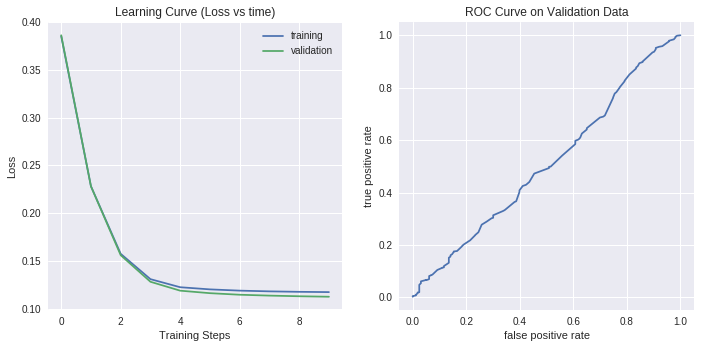

In [0]:
CATEGORICAL_FEATURES = ["gender"]
NUMERICAL_FEATURES = ["age", "occupation", "city_category", "city_years", 
                      "marital_status", "product_category", "purchase"]
FEATURES = NUMERICAL_FEATURES+CATEGORICAL_FEATURES
LABEL = "purchase_class"

LEARNING_RATE = 0.0005
STEPS = 1000
BATCH_SIZE = 50

linear_classifier = define_linear_classifier(learning_rate = LEARNING_RATE)
linear_classifier = train_model(
    linear_classifier, training_data2[FEATURES],
    training_data2[LABEL], validation_data2[FEATURES],
    validation_data2[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

In [0]:
evaluation_metrics = linear_classifier.evaluate(
 input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])
print("Loss on the validation set: %0.2f" % evaluation_metrics['loss'])

AUC on the validation set: 0.50
Accuracy on the validation set: 0.98
Loss on the validation set: 0.11


In [0]:
predict_test_input_fn = lambda: input_fn(
    test_data2[FEATURES], test_data2[LABEL], 
    num_epochs=1, shuffle=True)

In [0]:
evaluation_metrics = linear_classifier.evaluate(
 input_fn=predict_test_input_fn)

In [0]:
print("AUC on the test set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the test set: %0.2f" % evaluation_metrics['accuracy'])
print("Loss on the test set: %0.2f" % evaluation_metrics['loss'])

AUC on the test set: 0.51
Accuracy on the test set: 0.98
Loss on the test set: 0.11
